## Importing useful libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import spacy
from spacy.lang.en import STOP_WORDS
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import time

## Loading in the data

In [2]:
df = pd.read_csv("/content/drive/MyDrive/data2bot/Twitter_Suicide_Data_new.csv")

## EDA

In [3]:
tweet_data = df.copy() # making a copy of df as our working dataset. we don't want to mutate df

In [4]:
print(f"Shape of dataset is {tweet_data.shape}")
tweet_data.head() # checking the first five rows of the dataset

Shape of dataset is (303, 3)


,Id,Content,Sentiment
0,49640624.0,The end.,Negative
1,43505275.0,GOD OVER EVERYTHING.,Negative
2,43505275.0,I'm sorry.,Negative
3,43505275.0,God... please forgive me.,Negative
4,43505275.0,This day couldn't get any worse...,Negative


In [5]:
tweet_data.isnull().sum() # checking the number of Nan values in each feature

Id           0
Content      0
Sentiment    0
dtype: int64

#### As we can see, there are no Nan values in the dataset

In [6]:
len(tweet_data['Id'].unique()) # checking the number of unique elements in "Id" column

144

#### Since 144 is lesser than 303 (number of observations in the dataset), some IDs tweeted more than one tweet in the dataset. We will now check the Ids with the minimum and maximum number of tweets.

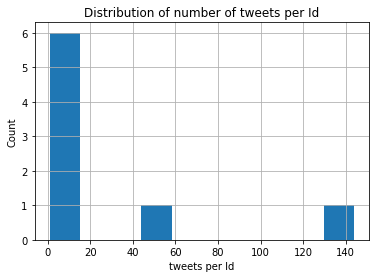

In [7]:
tweets_per_Id = tweet_data['Id'].value_counts()

# Histogram
tweets_per_Id.describe().hist()
plt.title("Distribution of number of tweets per Id")
plt.xlabel("tweets per Id")
plt.ylabel("Count")
plt.show()

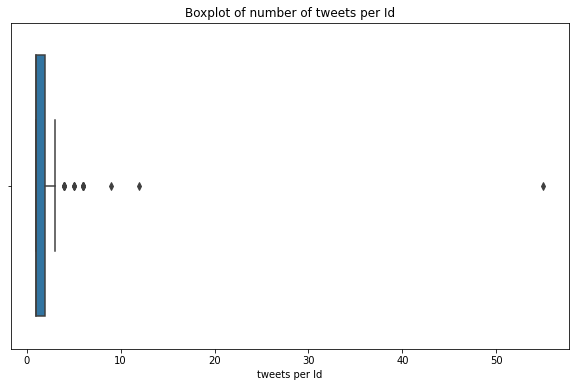

In [8]:
# boxpot
fig = plt.figure(figsize=(10, 6))
sns.boxplot(tweets_per_Id)
plt.title("Boxplot of number of tweets per Id")
plt.xlabel("tweets per Id")
plt.show()

#### We clearly see outliers in the number of tweets per Id. Let's have a closer look at the distribution of the number of tweets by Id by looking at the raw summary statistics.

In [9]:
tweets_per_Id.describe() # a summary statistics of the distribution to have a closer look

count    144.000000
mean       2.104167
std        4.738946
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       55.000000
Name: Id, dtype: float64

#### From the distribution plot and the summary statistics of the number of tweets per Id, we see that more than 50% of the number of tweets per Id is 1. Also, the maximum number of tweets per Id is 55. Let's see the share of positive sentiment of the tweets of the Id with 55 tweets. 

#### Note that tweets_per_Id is sorted in descending order by default. 

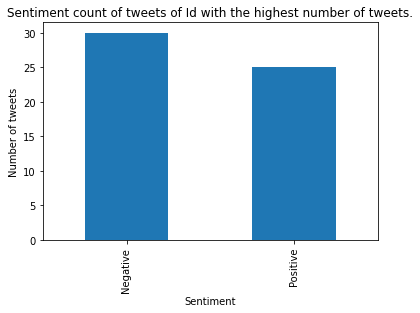

In [10]:
max_tweets_Id = tweet_data[tweet_data['Id'] == tweets_per_Id.index[0]]
max_tweets_Id['Sentiment'].value_counts().plot.bar()
plt.title("Sentiment count of tweets of Id with the highest number of tweets.")
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.show()

#### Since the number of positive and negative sentiments of the tweets of the Id with the highest number of tweets are almost equal, the user with this Id should probably be an ative user who share his/her thoughts via tweets. We will now have a view of some of this user's tweets.

In [11]:
# first five postive sentiment tweets of the user with the maximum number of tweets
max_tweets_Id_positive = max_tweets_Id[max_tweets_Id['Sentiment'] == "Positive"]
list(max_tweets_Id_positive['Content'].head())

['RT @LoniLove: Be true to yourself and love anyone your heart desires! #NationalComingOutDay https://t.co/uXUUAD3Nax',
 'RT @NOTORIOUSAALI: HOW U OUT HERE STRESSING &amp; HELPING PEOPLE, WHEN U AINT STRAIGHT YOURSELF??? U HAVE TO MAKE SURE UR GOOD BEFORE U COULD',
 "Learn to love yourself first. Be happy alone. No one will love you or be happy with you if you can't even do it.  them facts.",
 "RT @SEOKJIN_PH: ARMYs, after all of this, win or lose, reward youself.You deserve it.Don't beat yourself up.Love Yourself.",
 "RT @biebersmaniabrs: 'Love Yourself'"]

In [12]:
# first five negative sentiment tweets of the user with the maximum number of tweets
max_tweets_Id_negative = max_tweets_Id[max_tweets_Id['Sentiment'] == "Negative"]
list(max_tweets_Id_negative['Content'].head())

['Each day, each hour, each minute is just torture. I want it to end',
 "Waking up every day wishing I hadn't",
 'I feel like the only way to no longer carry this pain is to die',
 'I am weird and slow. Every social interaction is painfully awkward',
 'I want to finish my life']

#### From the tweets of the user with the maximum number  of tweets, we see that four of the first five postive sentiment tweets are re-tweets, while the negative sentiment tweets are direct tweets. Since we only looked at the first five tweets in each sentiment cateory for this user, we will now check the number of re-tweets of this user in each sentiment category.

In [13]:
print("The user with the highest number of tweets has {} of his/her positive sentiment tweets as retweets".format(\
                                          max_tweets_Id_positive['Content'].str.contains(r'^RT\s@', case=False).sum()))

The user with the highest number of tweets has 5 of his/her positive sentiment tweets as retweets


In [14]:
print("The user with the highest number of tweets has {} of his/her positive sentiment tweets as retweets".format(\
                                          max_tweets_Id_negative['Content'].str.contains(r'^RT\s@', case=False).sum()))

The user with the highest number of tweets has 0 of his/her positive sentiment tweets as retweets


### We that the user with the maximum number of tweets have only five of his/her tweets as re-tweets and no re-tweet of negative sentiment. We can say this user though sometimes get courage from others tweets (by retweeting them), but overall he/she tries to get self courage. Let's see some of his/her positve sentiment tweets that aren't retweets.

In [15]:
# first ten postive sentiment tweets of the user with the maximum number of tweets that aren't re-tweets
list(max_tweets_Id_positive[~max_tweets_Id_positive['Content'].str.contains(r'^RT\s@', case=False)]['Content'].head(10))

["Learn to love yourself first. Be happy alone. No one will love you or be happy with you if you can't even do it.  them facts.",
 'yourself! you can do anything if you want. you can be anything if you want. i love you! smile a lot and be happy for me too.',
 'Always love yourself first before you can love anyone else. Always put your self first bc in the end you will still have yourselves',
 'love u',
 'you are my love',
 'I Love Happy Music',
 'I Love Happy People',
 'I Love Happy Moments',
 "I Wish My True Love Happy Valentine's Day",
 'I Love Happy Faces']

#### We see that the user with the highest number of tweets voices out his/her positive sentiments via tweets and also tries to encourage others. He/she must be an active and user that alwyas share his/her thoughts.

#### We will now check the share of positive and negative sentiment in all tweets in the dataset.

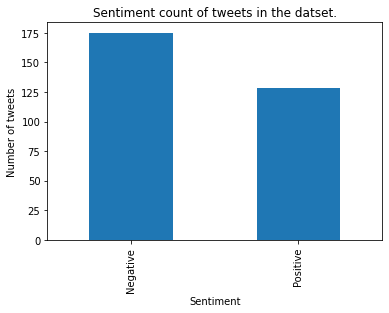

In [16]:
tweet_data['Sentiment'].value_counts().plot.bar()
plt.title("Sentiment count of tweets in the datset.")
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.show()

#### We see that the datset is not heavily unbalanced. This is good for classifier models. We will now check the percentage of retweets in each tweet sentiment category.

In [17]:
positive_Sentiments = tweet_data[tweet_data['Sentiment'] == "Positive"]
print("Percentage of positive sentiment tweets that are re-tweets in the dataset is {}%".format(\
                                      round(100*positive_Sentiments['Content'].str.contains(r'^RT\s@', case=False).sum()/positive_Sentiments.shape[0], 2)))

Percentage of positive sentiment tweets that are re-tweets in the dataset is 42.19%


In [18]:
negative_Sentiments = tweet_data[tweet_data['Sentiment'] == "Negative"]
print("Percentage of negative sentiment tweets that are re-tweets in the dataset is {}%".format(\
                                      round(100*negative_Sentiments['Content'].str.contains(r'^RT\s@', case=False).sum()/negative_Sentiments.shape[0], 2)))

Percentage of negative sentiment tweets that are re-tweets in the dataset is 15.43%


#### We see that overall, people tend to retweet positive sentiment in sucidal based tweets than tweets with negative sentiments. Let's see some of the negative sentiment tweets that are retweets to know how they look like.

In [19]:
# first ten postive sentiment tweets of the user with the maximum number of tweets that aren't re-tweets
list(negative_Sentiments[negative_Sentiments['Content'].str.contains(r'^RT\s@', case=False)]['Content'].head(10))

['RT @BlvckGrip: depression: i want to die',
 'RT @Pouyalilpou: I want to fucking die sometimes',
 "RT @memetribute: when people ask why your twitter is full of tweets of you just saying 'i want to die' repeatedly https://t.co/qQkNCxQ7Qx",
 'RT @RonnieRadke: Indirect tweets are cowardly. this tweet is direct to all the indirect. Indirectly. Courageously :)',
 'RT @RonnieRadke: Indirect tweets are cowardly. this tweet is direct to all the indirect. Indirectly. Courageously :)',
 'RT @gokaxmomurda408: Sometimes ifeel like my family would be better off without me.',
 'RT @AndreiTheWizard: Seems as if my family would be better off(and much happier) without me :',
 'RT @catpennies: #patriarchyis a fear of fatness, an idealization of whiteness, a quashing of sexuality, and a colonization of agency.',
 'RT @catpennies: #patriarchyis a fear of fatness, an idealization of whiteness, a quashing of sexuality, and a colonization of agency.',
 'RT @JillianChantal: Had one of those fretful nights. H

#### We see that negative sentiment tweets that were retweeted are either people trying to inform others of someone contemplating sucide (probably to find help for them) or people sending useful links on more info on sucidal based tweets that have negative sentiment.

## Data Cleaning

#### Checking for duplicates in the data.

In [20]:
def check_for_duplicate(d_f, col="Content"):
  """Checks for dupliactes"""
  if not d_f[col].unique().shape[0] == d_f.shape[0]: # if there are dupicates
    print("There are duplicate samples in the '{}' variable. Number of samples is {}, number of unique samples is {}".format(\
                                                                                col, d_f.shape[0], d_f[col].unique().shape[0]))

  else:
    print("There are no duplicates!")


In [21]:
check_for_duplicate(tweet_data) # checking for duplicates in 'Content' variable in the sucidal tweets dataset.

There are duplicate samples in the 'Content' variable. Number of samples is 303, number of unique samples is 295


In [22]:
check_for_duplicate(positive_Sentiments) # checking for duplicates in 'Content' variable in the positive sentiment tweets dataset.

There are duplicate samples in the 'Content' variable. Number of samples is 128, number of unique samples is 126


In [23]:
check_for_duplicate(negative_Sentiments) # checking for duplicates in 'Content' variable in the negative sentiment tweets dataset.

There are duplicate samples in the 'Content' variable. Number of samples is 175, number of unique samples is 169


In [24]:
# checking the class ratio of the dataset
(tweet_data['Sentiment'].value_counts() / tweet_data['Sentiment'].value_counts().iloc[1]).round(2)

Negative    1.37
Positive    1.00
Name: Sentiment, dtype: float64

#### So we see a class ratio of 1:1.37 (poisitive:negative). We will now remove duplicates in the dataset to further reduce the class ratio.

In [25]:
tweet_data[tweet_data['Content'].duplicated(keep=False)] # inspecting the duplicate tweets

,Id,Content,Sentiment
19,4.295150e+17,RT @RonnieRadke: Indirect tweets are cowardly....,Negative
20,4.295200e+17,RT @RonnieRadke: Indirect tweets are cowardly....,Negative
28,4.302570e+17,RT @catpennies: #patriarchyis a fear of fatnes...,Negative
29,4.302590e+17,RT @catpennies: #patriarchyis a fear of fatnes...,Negative
41,4.310550e+17,You'll be sorry when I'm gone.,Negative
53,4.310630e+17,You'll be sorry when I'm gone.,Negative
68,4.311090e+17,You'll be sorry when I'm gone.,Negative
120,9.195780e+17,RT @gilberra: This makes my heart full of joy....,Positive
122,9.195770e+17,RT @gilberra: This makes my heart full of joy....,Positive
148,9.195890e+17,RT @NiallOfficial: 2 wins in 2 weeks . Congrat...,Positive


#### After inpaecting the duplicated tweets, we see that the cause of dupicates is either users retweeting or tweeting a particular tweet. We see that the duplicated tweet contents have the same Sentiment. We handle these duplicates by dropping them. 

In [26]:
tweet_data.drop_duplicates(subset=['Content'], keep='first', inplace=True) # dropping duplicated sample and keeping only the first.

In [27]:
check_for_duplicate(tweet_data)

There are no duplicates!


In [28]:
nlp = spacy.load('en') # creating spacy pipeline

In [29]:
def clean_document(document):
  """clean document"""

  # convert to lower case, remove twitter handle, url, email, numbers and special characters.
  document = " ".join([word.lower_ for word in nlp(document) if not word.string.startswith('@') and not word.like_url and not word.like_email and
                       word.is_alpha])
  
  # lemmatize words, remove the spacy's personal pronoun lemma "-PRON-" and "rt" (which stands for retweet)
  document = " ".join([word.lemma_ for word in nlp(document) if word.lemma_ != '-PRON-' and word.text != 'rt'])

  return [word.text for word in nlp(document)]

In [30]:
stop_words = STOP_WORDS.copy() # making a cpy of spacy's stopwords
stop_words = clean_document(" ".join(STOP_WORDS)) # preprocessing stop words with same proprocessor for corpus

## Word Usage

#### We want to use how usage of words differ in the dataset. First, we will check words that have high usage across all documents, and words with low usage across all documents. We will use Tfidfvectorizer to achieve this. 

In [31]:
X = tweet_data['Content'] # selecting "Content" feature as the predictor
encoder = LabelEncoder() # initializing a LabelEncoder object for converting the labels to integers.
y = encoder.fit_transform(tweet_data['Sentiment']) 
encoder.classes_ # checking the classes and their labels

array(['Negative', 'Positive'], dtype=object)

In [32]:
# confirming that the label encoding was done such that 1 is positive, and 0 is negative
assert encoder.inverse_transform([1])[0] == "Positive"
assert encoder.inverse_transform([0])[0] == "Negative"

In [33]:
tfidf = TfidfVectorizer(tokenizer=clean_document, stop_words=stop_words) # initializing a TfidfVectorizer object.
Xt = tfidf.fit_transform(X) # vectorizing the corpus using tfidf

In [34]:
idf_sorted_feature = pd.Series(tfidf.get_feature_names())[tfidf.idf_.argsort()] # sorting tokens based on their tfidf scores
idf_sorted_feature.head(10) # top 10 words with high usage (low tfidf scores) across all tweets in the dataset  

361      life
379      love
661      want
163       die
267     happy
343      kill
250      good
194     enjoy
214    family
362      like
dtype: object

In [35]:
idf_sorted_feature.tail(10) # top 10 words with low usage (high tfidf scores) across all tweets in the dataset

263                    haidar
264                      hair
269                harassment
271                    harder
272                     harry
274    hbdanirudhbysuriyafans
275                      head
276                   healthy
304              idealization
695                  yourself
dtype: object

#### We will now create a word cloud of documents in tweets.

In [36]:
cleaned_tweets_df = tweet_data.copy() # creates a copy of the dataset.
cleaned_tweets_df['Content'] = cleaned_tweets_df['Content'].apply(lambda tweet: " ".join(clean_document(tweet))) # cleaning the tweets

#### We will now compare the cleaned tweets to the original tweets to see if the cleaning was properly done.

In [37]:
cleaned_tweets_df.head()

,Id,Content,Sentiment
0,49640624.0,the end,Negative
1,43505275.0,god over everything,Negative
2,43505275.0,i sorry,Negative
3,43505275.0,god please forgive,Negative
4,43505275.0,this day could get any bad,Negative


In [38]:
tweet_data.head()

,Id,Content,Sentiment
0,49640624.0,The end.,Negative
1,43505275.0,GOD OVER EVERYTHING.,Negative
2,43505275.0,I'm sorry.,Negative
3,43505275.0,God... please forgive me.,Negative
4,43505275.0,This day couldn't get any worse...,Negative


#### By comparinig the two dataframes above, we see that the tweets were properly cleaned.

#### Checking the summary of the number of words in a tweet after cleaning. We don't want a tweet to be empty after cleaning as this will negatively affect the performance of our model.

In [39]:
len_words = cleaned_tweets_df['Content'].apply(lambda x: len(x.split()))
len_words.describe()

count    295.000000
mean      10.494915
std        6.368968
min        1.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       45.000000
Name: Content, dtype: float64

#### From the results above, we see that the minimum number words in a tweet after cleaning is 1. We may want to check out this tweet.

In [40]:
cleaned_tweets_df[len_words == 1]

,Id,Content,Sentiment
31,4.305680e+17,shamefaced,Negative
40,4.309120e+17,reproachful,Negative
78,4.311200e+17,disappointed,Negative
104,4.311460e+17,depressed,Negative
111,2.377192e+09,enjoy,Positive
211,9.199330e+17,love,Positive


#### We see that although the minimum number of words in a tweets after cleaning is 1, these words are words that can each tell of the sentiment of a tweet. As a result, we will not be dropping them. 

#### Since stop-words were removed in the tfidf vectorizer, we will further confirm that there are no empty tweets after removing stopwords. If a tweet is empty, the sum of the tfidf scores of its words will be zero, because the ter, frequency will be zero. 

In [41]:
if (Xt.todense().sum(axis=1) == 0).sum():
  print("There is at least one tweet that is empty after cleaning and removing stopwords")
else:
    print("No tweet is empty after cleaning and removing stopwords")

No tweet is empty after cleaning and removing stopwords


#### We will now visualize the word cloud.

In [42]:
img1 = np.array(Image.open('/content/drive/MyDrive/happiness-dom-success-friendship.jpg'))
img2 = np.array(Image.open('/content/drive/MyDrive/depression.jpg'))

In [43]:
img1.shape

(535, 400, 3)

In [44]:
img2.shape

(601, 448)

In [45]:
Image.open('/content/drive/MyDrive/Jump_Joy_547133_3400x4500.jpg').size

(3400, 4500)

In [46]:
Image.open('/content/drive/MyDrive/depression.jpg').size

(448, 601)

In [47]:
def get_word_cloud(d_f, title, col='Content', mask=None):
  """Plots the word cloud of tweets"""

  wordcloud = WordCloud(background_color="white", collocations=False, mask=mask).generate(" ".join(d_f[col]))
  plt.figure(figsize=(10,7))
  plt.title(title)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

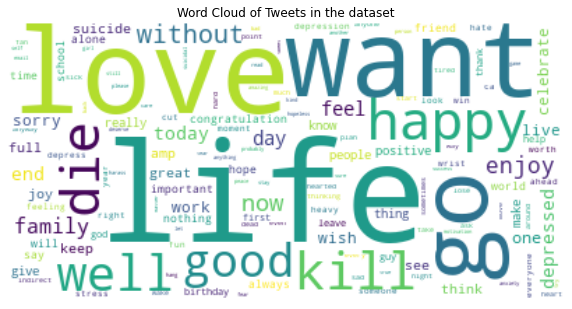

In [48]:
get_word_cloud(cleaned_tweets_df, "Word Cloud of Tweets in the dataset")

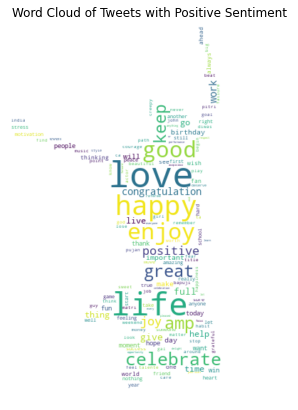

In [49]:
# word cloud of positive sentiment
cleaned_positive_tweets = cleaned_tweets_df[cleaned_tweets_df['Sentiment'] == 'Positive'] # filtering out tweets with positive sentiment
get_word_cloud(cleaned_positive_tweets, "Word Cloud of Tweets with Positive Sentiment", mask=img1)

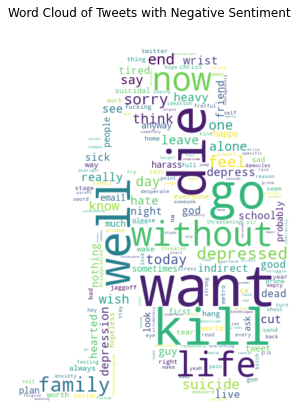

In [50]:
# word cloud of negative sentiment
cleaned_negative_tweets = cleaned_tweets_df[cleaned_tweets_df['Sentiment'] == 'Negative'] # filtering out tweets with negative sentiment
get_word_cloud(cleaned_negative_tweets, "Word Cloud of Tweets with Negative Sentiment", mask=img2)

## Modeling

#### In this section, we will build different classfier models using a 5 fold stratified cross validation strategy (so as to reduce overfitting and preserve class ratio). We will monitor the accuracy and f1 scores. Accuracy for overall performance on correct predictions, f1_score to account for class imbalance.

In [51]:
cv = StratifiedKFold(n_splits=5, random_state=42) # stratified kfold object to preserve class ratio per split
vectorizer = TfidfVectorizer(tokenizer=clean_document, stop_words=stop_words) # initializing a TfidfVectorizer object.

 # classifiers dictionary
classifiers = {'log_reg': LogisticRegression(), 'naive_bayes': MultinomialNB(), 'random_forest': RandomForestClassifier(random_state=42),
               'extra_tress': ExtraTreesClassifier(random_state=42)}

In [52]:
def to_mins_seconds(seconds):
  """Function to convert seconds to mins and seconds"""

  mins = int(seconds // 60) 
  sec = round(seconds % 60)

  return str(mins) + "mins: " + str(sec) + "secs" 

In [53]:
def get_models_performances(classifiers, X=X, y=y, transformer=vectorizer, cv=cv, metrics=['accuracy', 'f1'], verbose=True):
  """Train classifiers and return cross validation results for each classifier"""

  t_start = time.time() # starts time for total elasped time
  cv_results = [] # epmty list for storing cross validation results

  for idx, classifier in zip(range(len(classifiers)), classifiers.keys()):
    t0 =time.time() # starts time for each model
    model = Pipeline([('vectorizer', vectorizer), ('classifier', classifiers[classifier])]) # build model pipeline
    results = cross_validate(model, X, y, scoring=metrics, cv=cv, return_train_score=True, n_jobs=-1) # cross validation result
    cv_results.append(results)

    if verbose:
      print(f"Done {idx+1} of {len(classifiers)}, trained {classifier} model. Elasped time is {to_mins_seconds(time.time()-t0)}\n")

  if verbose:
    print(f"Training and testing completed! Total elasped time is {to_mins_seconds(time.time()-t_start)}\n")
  
  cols = ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1'] # training and testing metircs names

  # return a dataframe of the cross validation scores.
  return pd.DataFrame([[cv_result[col].mean() for col in cols] for cv_result in cv_results], index=list(classifiers.keys()), columns=cols)

In [54]:
get_models_performances(classifiers)

Done 1 of 4, trained log_reg model. Elasped time is 1mins: 24secs

Done 2 of 4, trained naive_bayes model. Elasped time is 1mins: 28secs

Done 3 of 4, trained random_forest model. Elasped time is 1mins: 25secs

Done 4 of 4, trained extra_tress model. Elasped time is 1mins: 25secs

Training and testing completed! Total elasped time is 5mins: 41secs



,train_accuracy,test_accuracy,train_f1,test_f1
log_reg,0.982203,0.820339,0.978679,0.737027
naive_bayes,0.985593,0.861017,0.982842,0.820626
random_forest,1.000000,0.769492,1.000000,0.642603
extra_tress,1.000000,0.783051,1.000000,0.676008


#### From the results above, we see that with the default hyperparameters of the classifiers, Naive Bayes classifier is the best as it is less overfitted and has a pretty good cross validation and accuracy and f1_scores. We may want to improve the model's performance further by tuning the hyperparamters of this model. 

#### We will train our final model for production. This model handles out of vocabulary words by ignoring them.

In [55]:
final_model = Pipeline([('vectorizer', vectorizer), ('classifier', MultinomialNB())])
final_model.fit(X, y);